In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 


df = pd.read_csv('fifa_clean.csv')
df = df.drop('Release.Clause',1)
df.head()

,Name,Age,Nationality,Overall,Potential,Club,Wage,Special,Preferred.Foot,International.Reputation,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,L. Messi,31,Argentina,94,94,FC Barcelona,565000.0,2202,Left,5.0,...,66,63,63,63,66,61,49,49,49,61
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,405000.0,2228,Right,5.0,...,68,64,64,64,68,64,56,56,56,64
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,290000.0,2143,Right,5.0,...,68,63,63,63,68,63,50,50,50,63
3,De Gea,27,Spain,91,93,Manchester United,260000.0,1471,Right,4.0,...,0,0,0,0,0,0,0,0,0,0
4,K. De Bruyne,27,Belgium,91,92,Manchester City,355000.0,2281,Right,4.0,...,80,80,80,80,80,76,69,69,69,76


In [2]:
def treeimp_df(model, X):
    coefs = pd.DataFrame({'name': X.columns, 'coef' : model.feature_importances_})
    coefs = coefs.sort_values('coef', ascending = False)
    return(coefs)


def treeimp_plot(model, X, n = 50, figsize = (12, 8)):
    coefs = treeimp_df(model, X)
    plt.figure(figsize = figsize)
    sns.pointplot(y="name", x="coef",
                  data=coefs.head(n), ci=None, color = 'C0')
    sns.barplot(y = "name", x= "coef", data=coefs.head(50), ci=None, color = 'C0', alpha = 0.2)
    plt.title('Coeficient Plot')
    plt.tight_layout()
    


start by looking at distribution of variables:

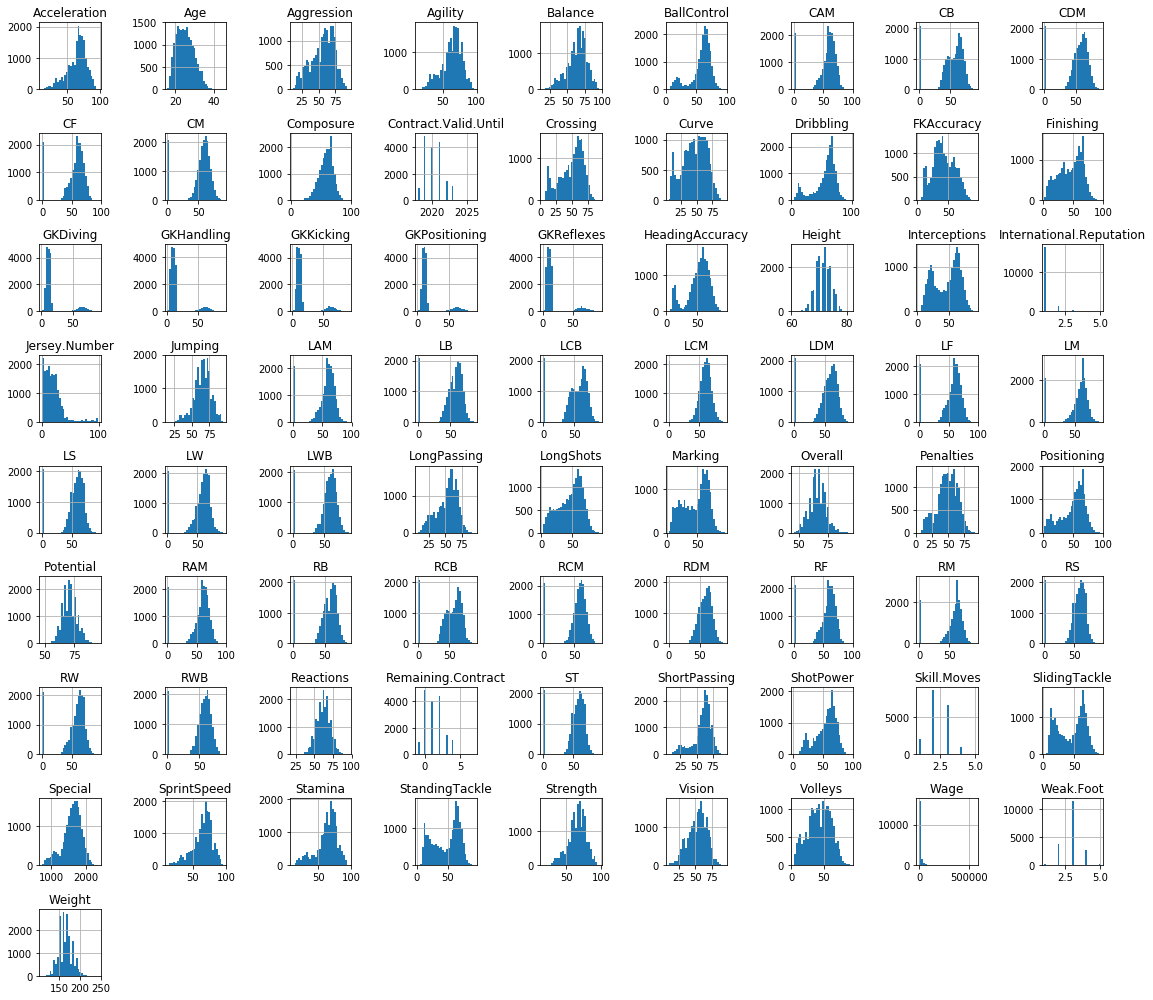

In [3]:
df.hist(figsize = (16,14), bins = 30)
plt.tight_layout()
plt.show()

* Many non-normal / bimodal 

* May need to do log transformations

In [ ]:
numerics = df.select_dtypes(['int64', 'float64'])
for i in numerics.columns:
    if i == "Wage":
        pass
    else:
        plt.figure(figsize = (12, 6))
        sns.regplot(df[i], df['Wage'], data = df[[i, 'Wage']].dropna())
        plt.show()
    

In [4]:
cats = df.select_dtypes(['object'])
for i in cats.columns:
    print(i)

Name
Nationality
Club
Preferred.Foot
Work.Rate
Body.Type
Position
Loaned.From


<Figure size 864x576 with 0 Axes>

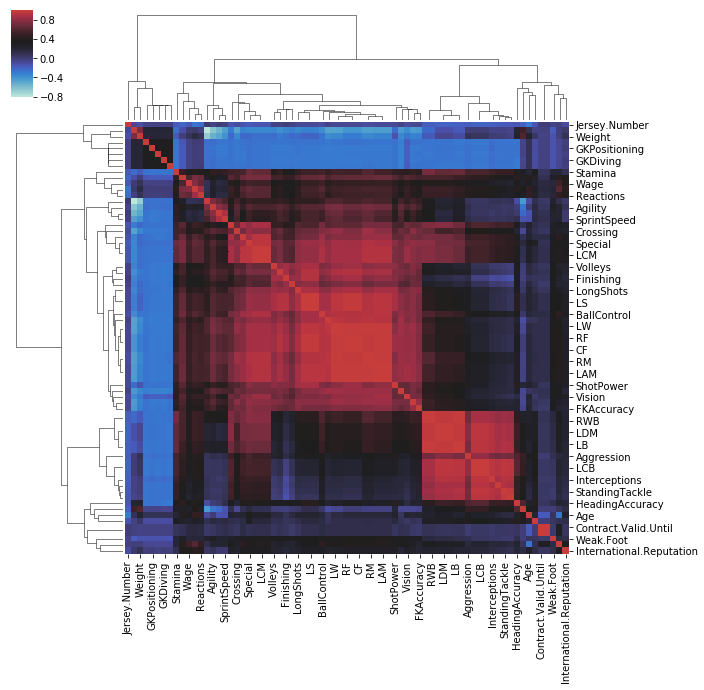

In [5]:
cormat = df.corr(method = 'spearman')
plt.figure(figsize = (12, 8))
sns.clustermap(cormat, center = np.median(cormat))
plt.show()

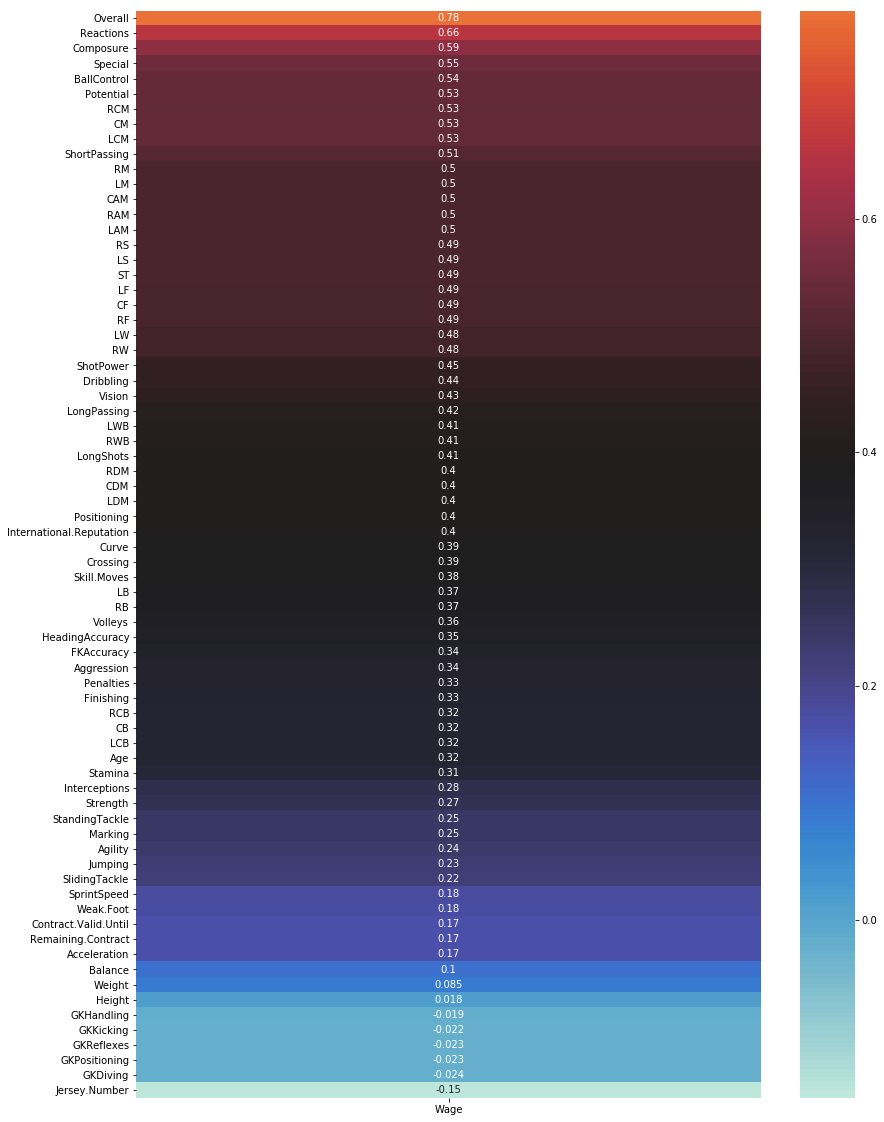

In [6]:
wage_cor = cormat[['Wage']].sort_values(by = 'Wage', ascending = False)[1:]
plt.figure(figsize = (14, 20))
sns.heatmap(wage_cor, annot=True, center = np.median(wage_cor))
plt.show()

Create train test splits and deal with categorical variables:

A quick trick that I often use to deal with high cardinality categorical variables is to keep the most frequent values and discard the rest.  This certainly introduced information loss, but helps to create a good defensible model quickly.

In [7]:
from sklearn.model_selection import train_test_split

df = pd.get_dummies(df.drop('Name', 1))
y = df['Wage']
X = df.drop('Wage', 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

for col in X_train.select_dtypes('object').columns:
    top = train[col].value_counts().head(10)
    X_train[col] = [x if x in top else "other" for x in train[col]]
    X_test[col] = [x if x in top else "other" for x in test[col]]

print(X_train.shape)

(12744, 1276)


## Models: 

### Gradient Boosting Regressor:

Very similar to random forest, fits quite a bit faster and actually tends to perform a bit better than random forests.

Extra trees regressor performs strong without tuning:

0.8952714256880757


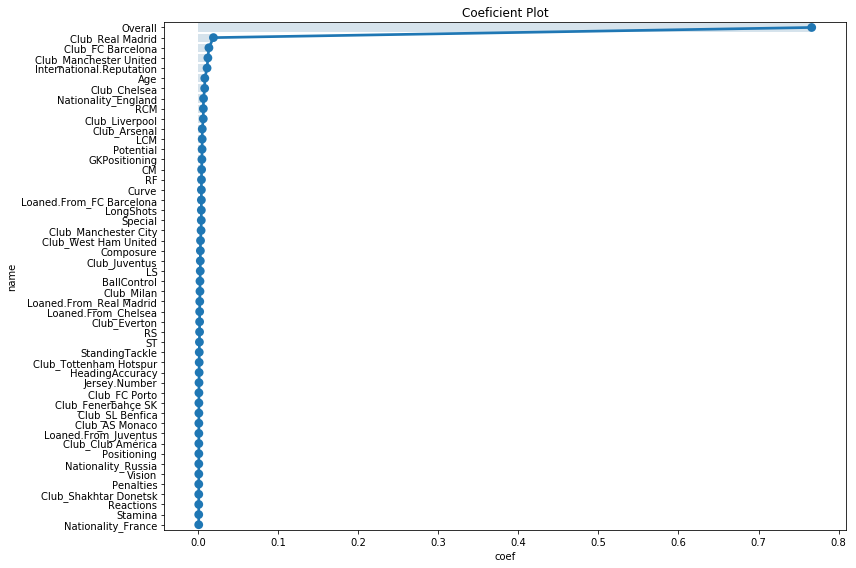

In [8]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer



pipe = Pipeline([('imp', SimpleImputer(strategy = 'most_frequent')),
                ('gbm', GradientBoostingRegressor(n_estimators = 500))
            ])

pipe.fit(X_train, y_train)
print(pipe.score(X_test, y_test))
tree = pipe.named_steps['gbm']
treeimp_plot(tree, X)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer



pipe = Pipeline([('imp', SimpleImputer(strategy = 'most_frequent')),
                ('rf', RandomForestRegressor())
            ])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
tree = pipe.named_steps['rf']
treeimp_plot(tree, X)

In [9]:
from xgboost.sklearn import XGBClassifier 
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "xgb__n_estimators": st.randint(3, 40),
    "xgb__max_depth": st.randint(2, 40),
    "xgb__learning_rate": st.uniform(0.001, 0.4),
    "xgb__colsample_bytree": one_to_left,
    "xgb__subsample": one_to_left,
    "xgb__gamma": from_zero_positive,
    'xgb__reg_alpha': from_zero_positive,
    "xgb__min_child_weight": from_zero_positive,
}

 


pipe = Pipeline([('imp', SimpleImputer(strategy = 'most_frequent')),
                ('xgb', XGBClassifier(nthreads=-1))
            ])

pipe.fit(X_train, y_train)

grid_gbm = RandomizedSearchCV(estimator=pipe,
                       param_distributions=params,
                       cv=3,
                       verbose=0,
                       n_jobs=-1, 
                       n_iter = 3)

grid_gbm =grid_gbm.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
top = treeimp_df(tree, X).head(50)['name'].tolist()
X_train = X_train[top]
X_test = X_test[top]